### In case that your kernel does not have the following libraries installed ...

# Configuration

In [1]:
%load_ext autoreload
%autoreload 2

from cfg import *
sys.path.append('libraries')

from utils import *
import BrainPlotter_beta as BP

sys.path.append('atlasoverlay')
import atlasoverlay as ao

import AllenRegistration as AR_Lib
import VisuAlignLib
import convertAllenSpace as CAS
from flatmapper import FlatMapper

current_path = os.path.abspath('../')  # to be replaced with os.getcwd()  
# main_path = os.path.abspath('../../')  # To be removed ...

# Choose directories for pre-process atlas files, flatmap files, input dataset and other code repositories 
data_repository = 'atlas_files' #os.path.join(main_path,'Data Repositories/mouse_connectivity')
sys.path.append(data_repository)

flatmap_repository = 'annotation_overlays'
sys.path.append(flatmap_repository)

dir_data = os.path.join(current_path, 'Datasets/BDA_double_classifier') # To be replaced with 'Datasets'
sys.path.append(dir_data)

# code_dir = os.path.join(main_path,'Code Repositories')  # Set your path for the code repositories here ...
# sys.path.append(code_dir)

# Choose your DeepSlice directory
# dir_deepslice = os.path.join('/cortexdisk/data2/NestorRembrandtCollab/Code Repositories', 'DeepSlice/DeepSlice') 
dir_deepslice = input("Set your path for the DeepSlice library: ")
sys.path.append(f'{dir_deepslice}')

# Choose your ilastik classifier here
classifier = os.path.join(os.getcwd(), 'Ilastik_Classifiers', 'universal_classifier_v06.ilp')

# Choose a directory to save your output 
dir_img_output = 'Saves'  #os.path.join(current_path,'Saves')
save_figure_dir = 'Figures' #os.path.join(current_path,'Figures')

# Choose path to the ilastik tool - Change !!
# ilastik_fname = 'ilastik-1.4.0rc5-Linux'
# ilastik_path = os.path.join('/cortexdisk/data2/NestorRembrandtCollab/Code Repositories',ilastik_fname)
ilastik_path = input("Set your path for the ilastik software: ")
    

Set your path for the DeepSlice library: a
Set your path for the ilastik software: a


In [3]:
# Replace with a configuration file

# sections that require mirroring
imgs2mir = {'BDA020': [145, 146, 147, 151, 156, 161], 
            'BDA048': [152, 153], 
            'BDA049': [137], 
            'BDA081': [143]}

# sections that require rotation
imgs2rot = {'BDA097': [141], 
            'BDA101': [151, 161]}


datasets_to_check = os.listdir(dir_data)
data_directory = [os.path.join(dir_data,val) for val in datasets_to_check]
Marios_populations = ['BDA046','BDA050','BDA061','BDA074','BDA081','BDA089','BDA098']
cmap = ['#FF0000','#FFFF00','#BF40BF','#00FFFF','#0000FF','#FFA500','#90EE90','#884400','#000088','#0088DD',"#00FF00"]

source_area = 'VPM'

# Here choose whether you want to save your registered files or load pre-computed ones
save_registration = True
load_registration = False


# Load relevant atlas files

In [4]:
# Get Allen atlas data either pre-computed or downloaded from the Allen Institute if not found
res = 10
annotation,acr2id,id2acr,ancestorsById,template = getAtlasData(data_repository, resolution = res)
# YSK_annotation, ysk_hdr = nrrd.read("/cortexdisk/data2/NestorRembrandtCollab/Data Repositories/mouse_connectivity/YSK_annotation_10.nrrd") # corrected path 

# Choose ilastik mode
cls_splt = classifier.split('/')
classifier_name = cls_splt[len(cls_splt)-1]
classifier_mode = '"Simple Segmentation"'

# Remove later, kept only for debugging purposes ...
# orig_target_dict = pk.load(open('../Saves/test_target_dict.pkl','rb'))
hex2rgb = lambda x : tuple(int(x.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
target_color = []
for pop in range(len(cmap)):
    tmp_clr = hex2rgb(cmap[pop])
    if tmp_clr == (0,0,0):
        tmp_clr = [52,52,52]
    target_color.append(tmp_clr)
    

# Choose which parts of the pipeline to perform/repeat ...

In [5]:
do_downsampling = False
do_fixes = False
do_deepslice = False
do_quicknii = False
do_visualign = False
do_pylastik = True
do_register = False

# Functions

The following functions ask for several directories. They should be structured like this: 

    expdir (i.e.: 'BDA061', or whatever your experiment name is)
        imgdir ('original_images', the folder where the input images are stored)
        downdir ('import', the folder where the downsampled images are stored)

In [ ]:
voxel_to_value_source = OrderedDict()
voxel_to_value_target_left = OrderedDict()
voxel_to_value_target_right = OrderedDict()

# Remove ...
exp_list = []

# Iterate over all experiments ...
successful_reg = 0

for experiment_id in os.listdir(dir_data): 
    if experiment_id not in Marios_populations or load_registration is True: continue  # For debugging purposes, remove ...
    print(experiment_id) 
    
    in_dir = os.path.join(dir_data,experiment_id) 
    AR = AR_Lib.Allen_Registration(annotation, template, in_directory = data_repository, 
                                   in_res = res, soma_acr = source_area, acr2id = acr2id,
                                   in_color = cmap[successful_reg], data_dir = dir_data,
                                   experiment_id = experiment_id)#, annot2 = YSK_annotation)
    
    (expdir, imgdir, downdir) = AR_Lib.setup(experiment_id, dir_data)
    
    ''' Part I: Downsampling. Due to memory issues, 
        QuickNii only allows images whose area is smaller than 16 million pixels. 
        Therefore, the JP2 images have to be downsampled to the appropiate size. 
    '''
    if do_downsampling is True:
        print('Commencing downsampling')
        AR_Lib.addnumbers(imgdir)
        AR_Lib.downsample(imgdir, downdir) 
    
    ''' Part II: Fixes (rotation, mirroring). Some sections were mounted onto the slide in the wrong position. 
        This has to be fixed. Some are flipped horizontally and require to be mirrored; 
        others are upside down, and require to be rotated 180 degrees. 
    '''
    if do_fixes is True:
        print('Commencing pre-processing fixes')
        AR_Lib.rotate_imgs(downdir, imgs2rot, del_oldfile=True)
        AR_Lib.mirror_imgs(downdir, imgs2mir, del_oldfile=True)
    
    ''' Part III: Apply DeepSlice to the input slices'''
    if do_deepslice is True:
        print('Commencing DeepSlice step')
        AR_Lib.deepslice_analysis(expdir)
    
    ''' Part IV: Apply QuickNii to the slices after DeepSlice. 
        This QuickNii application is manual. Store output in xml.'''
    if do_quicknii is True:
        print('Commencing Quicknii step')
        xml_file = f'{expdir}/{experiment_id}_deepslice.xml'
        tree = ET.parse(xml_file)
        root = tree.getroot()
        AR_Lib.sortchildrenby(root, 'filename')
        for child in root:
            AR_Lib.sortchildrenby(child, 'filename')
        tree.write(f'{xml_file[:-4]}_sorted.xml')
    
    ''' Part V: Apply VisuAlign to the data. This step is completely manual. 
        First, check that the QuickNii registration is satisfactory. 
        If not, make the appropiate corrections. 
        Then create the json file with the following code, load it into VisuAlign 
        and perform the non-linear registration. 
        Focus on the targeted areas (thalamus, cortex). 
    '''
    if do_visualign is True:
        print('Commencing VisuAlign step')
        AR_Lib.xmltojson(xml_file)
        for file in os.listdir(expdir): 
            if '.xml' not in file: continue
            if 'manual' not in file: continue
            print(file)
        
    ''' After the registration is done, make sure to: 
        - Use the option to export everything from VisuAlign, and save it in './data/export'
        - Check that the downsampled images registered in VisuAlign are stored in './data/import'
        - Save the output .json file from VisuAlign in './data'
    '''
    
    ''' Part VI: Segment slices using Ilastik. un Ilastik in headless mode from Python through the pylastik function. 
        You'll need to manually train a classifier to run this step. If you encounter a problem, 
        first check that you can run the classifier manually. '''
    
    if do_pylastik is True:
        print('Commencing Ilastik step')
        AR_Lib.run_pylastik(in_dir, classifier_name, ilastik_path, classifier_mode)
        # Reveal and clean Segmentation 
        AR_Lib.reveal(expdir)
        AR_Lib.clean_segmentation(expdir) #Update soon ... #in_dir, in_slice['filename']) # Here I should clean the image ...
    
    ''' Part VII: Inverse mapping of slices to Allen CCF. First, search if the respective json file exists 
        and if it can be opened successfully.
        If not, then the VisuAlign registration was not performed properly for this experiment,
        and this population has thus to be skipped.'''
    
    if do_register is True:
        print('Commencing inverse registration step')
        reg_flag = AR.register_sections(experiment_id)
        ## Separate the two hemispheres and flip them for visualization purposes 
        left_target_dict, right_target_dict = AR.split_hemisphere('target')
    
    ''' Part VIII: Storing the registered volumes to a population-wide 3D structure 
        for post-hoc analysis and visualization\
    '''
    
    successful_reg+=1
    voxel_to_value_source[experiment_id] = AR.source_dict
    voxel_to_value_target_left[experiment_id] = left_target_dict
    voxel_to_value_target_right[experiment_id] = right_target_dict
    
    # Remove ...
    tmp_clr = hex2rgb(cmap[pop])
    if tmp_clr == (0,0,0):
        tmp_clr = [52,52,52]
    target_color.append(tmp_clr)
    exp_list.append(experiment_id)
    

## Save your files, or load pre-computed ones

In [96]:
if save_registration = True:
    pk.dump(voxel_to_value_target_left, open('Saves/BDA_all_target_left_10.pkl','wb'))
    pk.dump(voxel_to_value_target_right, open('Saves/BDA_all_target_right_10.pkl','wb'))
    pk.dump(voxel_to_value_source, open('Saves/BDA_all_source_10.pkl','wb'))


In [ ]:
if load_registration = True:
    voxel_to_value_target_left = pk.load(open('Saves/BDA_all_target_left_10.pkl','rb'))
    voxel_to_value_target_right = pk.load(open('Saves/BDA_all_target_right_10.pkl','rb'))
    voxel_to_value_source = pk.load(open('Saves/BDA_all_source_10.pkl','rb'))


## Cortical flatmap and subcortical visualization plots

In [ ]:
data_dir = 'annotation_overlays/' #'/cortexdisk/data2/NestorRembrandtCollab/Data Repositories/annotation_overlays/'
atlas_overlay_dir = 'atlasoverlay/'  
flatmapper_dir = 'cortical_coordinates/' #os.path.join(main_path,'Rembrandt_works/flatmapper/cortical_coordinates')
maps = ['top_view', 'dorsal_flatmap']
annotation_types = ['YSK','allen']
hemi_acr = 'left'

# Fix savefile ..
fimap = maps[0]
for annot in annotation_types:
    target_savefile = f'{save_figure_dir}/all_{fimap}_{res}um_{annot}_{hemi_acr}_{annot}'   #experiment_id                                   
    
    # Left hemisphere target plots ...
    rgb_export_target = BP.plot_flatmap(voxel_to_value_target_left, proj_type = 'dorsal_flatmap', data_dir = data_dir, 
                                        atlas_overlay_dir = atlas_overlay_dir, flatmapper_dir = flatmapper_dir, 
                                        annot = annot, target_color = target_color, hemisphere = hemi_acr, 
                                        savefile = target_savefile + '_left')

    # Right hemisphere target plots ...
    rgb_export_target_r = BP.plot_flatmap(voxel_to_value_target_right, proj_type = 'dorsal_flatmap', data_dir = data_dir, 
                                          atlas_overlay_dir = atlas_overlay_dir, flatmapper_dir = flatmapper_dir, 
                                          annot = annot, target_color = target_color, hemisphere = hemi_acr, 
                                          savefile = target_savefile + '_right')

# Source plots ...
plane = 'IR' # We want coronal sections for now
source_savefile = os.path.join(save_figure_dir,'BDA_all_{}_{}_left.svg'.format(source_area, plane))
rgb_export_source = BP.plot_plane(voxel_to_value_source, annotation, template, acr2id, 'VPM', in_color = target_color, 
                                  in_path = atlas_overlay_dir, sel_axis = plane, orient = 'left', 
                                  savefile = source_savefile, style = 'max', section = None)


## Plotting the laminar distribution of the populations

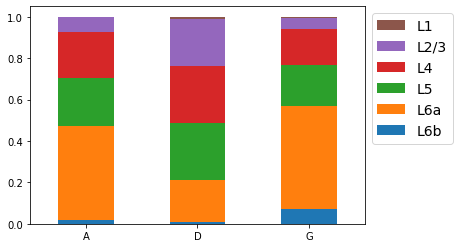

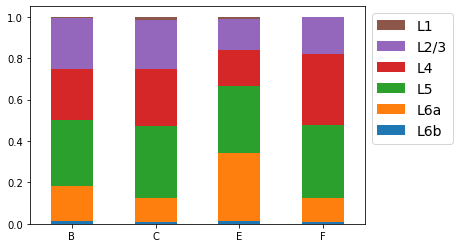

In [44]:
from itertools import cycle, islice

''' The following two line is to be removed '''
exp_list = list(voxel_to_value_source.keys())

''' Extract laminar statistics '''
area_layer_dict, axon_stats = AR.get_area_stats(voxel_to_value_target_left)

''' Align the labels to the poster ones '''
area_layer_dict_new = deepcopy(area_layer_dict)
rename_index = {'BDA046': 'A', 'BDA061' : 'C', 'BDA081' : 'D', 'BDA089': 'B', 'BDA050': 'E', 'BDA074' : 'F', 'BDA098' : 'G'}
area_layer_dict_new['SSp'] = area_layer_dict_new['SSp'].rename(index = rename_index).sort_index()
area_layer_dict_new['SSp'] = area_layer_dict_new['SSp'].reindex(sorted(area_layer_dict_new['SSp'].columns)[::-1], axis=1)
area_layer_dict_new['SSs'] = area_layer_dict_new['SSs'].rename(index = rename_index).sort_index()
area_layer_dict_new['SSs'] = area_layer_dict_new['SSs'].reindex(sorted(area_layer_dict_new['SSs'].columns)[::-1], axis=1)

''' Plot SSp populations '''
plot1 = area_layer_dict_new['SSp'].plot(kind='bar', stacked=True, rot=0) #color = colors_ssp, 
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plot1.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.0, 1.0), fontsize=14)
# fig1 = plot1.get_figure()
# plt.savefig('Figures/population_barplot_ssp_{}_merged.eps'.format(experiment_id), bbox_inches = 'tight')
plt.show()

''' Plot SSs populations '''
plot2 = area_layer_dict_new['SSs'].plot(kind='bar', stacked=True, rot=0) #color = colors_sss, 
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
plot2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.0, 1.0), fontsize=14)
# fig2 = plot2.get_figure()
# plt.savefig('Figures/population_barplot_sss_{}_merged.eps'.format(experiment_id), bbox_inches = 'tight')
plt.show()



## Connecting the pipeline to the SBA Composer 

In [45]:
import rpc_interface

sbaHostAlpha = 'https://neuroinformatics.nl/sba-alpha/www'
sbaHostIncf = 'https://sba-dev.incf.org'
sbaInterface = rpc_interface.RpcInterface(
  'sbaInterface',
  remoteUrl = '{}/{}?{}'.format(sbaHostAlpha,'composer','template=ABA_v3&scene={"background":"FFFFFF"}'),
  interfaceScript = sbaHostIncf+'/js/rpc-interface.js'
)
    

In [ ]:
''' Iterate over all populations to build 3D point-objects that can be visualized using SBA '''
for pop_idx,pop_name in enumerate(voxel_to_value_source.keys()):
 
    print(pop_idx, pop_name, target_color[pop_idx])
    
    target_point_cloud = voxel_to_value_target_left[pop_name]
    x3dScene, sbaCommand = AR.image_to_x3d(target_point_cloud, target_color[pop_idx], labelIndex = 2, 
                                           filename = pop_name + '_target')  
    sbaInterface.send(sbaCommand)
    
    source_point_cloud = voxel_to_value_source[pop_name]
    x3dScene, sbaCommand = AR.image_to_x3d(source_point_cloud, target_color[pop_idx], labelIndex = 3,  
                                           filename = pop_name + '_soma')
    sbaInterface.send(sbaCommand)
    
    